In [1]:
from main_ForecastPFN import *

2023-04-25 21:38:30.786087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-25 21:38:30.840750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-25 21:38:30.841185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
path = 'project/shared/repeats=0,lookback_period=2,loss_name=MAPE,source_dataset=M4'

In [3]:
experiment_parameters = load_experiment_parameters(path)
source_dataset_name = experiment_parameters['source_dataset'] if 'source_dataset' in experiment_parameters else 'M4'
loss_name = experiment_parameters['loss_name']

model_horizons = {
    'Y4': 4,
    'Y6': 6,
    'Q8': 8,
    'M18': 18,
    'M24': 24,
    'W13': 13,
    'D14': 14,
    'H24': 24,
    'H48': 48,
}

if source_dataset_name == 'M4':
    source_dataset, _ = M3Dataset(M3Meta.dataset_path).standard_split()
    model_sps = {
        'Y4': 'Yearly',
        'Y6': 'Yearly',
        'Q8': 'Quarterly',
        'M18': 'Monthly',
        'M24': 'Monthly',
        'W13': 'Weekly',
        'D14': 'Daily',
        'H24': 'Hourly',
        'H48': 'Hourly',
    }
elif source_dataset_name == 'FRED':
    source_dataset, _ = FredDataset(FredMeta.dataset_path).standard_split()
    model_sps = {
        'Y4': 'Yearly',
        'Y6': 'Yearly',
        'Q8': 'Quarterly',
        'M18': 'Monthly',
        'M24': 'Monthly',
        'W13': 'Monthly',
        'D14': 'Monthly',
        'H24': 'Monthly',
        'H48': 'Monthly',
    }
elif source_dataset_name == 'M3':
    source_dataset, _ = M3Dataset(M3Meta.dataset_path).standard_split()
    model_sps = {
        'Y4': 'M3Year',
        'Y6': 'M3Year',
        'Q8': 'M3Quart',
        'M18': 'M3Month',
        'M24': 'M3Month',
        'W13': 'M3Month',
        'D14': 'M3Other',
        'H24': 'M3Other',
        'H48': 'M3Other',
    }
else:
    raise Exception(f'Unknown source dataset {source_dataset_name}')

tl_models = {}
for model_name, horizon in model_horizons.items():
    input_size = experiment_parameters['lookback_period'] * horizon
    model = Exp_ForecastPFN(None)

    tl_models[model_name] = {'p_model': model, 'p_input_size': input_size, 'p_horizon': horizon}
print(tl_models['M18'])

{'p_model': <exp.exp_ForecastPFN.Exp_ForecastPFN object at 0x7f8be09d2220>, 'p_input_size': 36, 'p_horizon': 18}


In [4]:
target_input, target_output = M3Dataset(
        M3Meta.dataset_path).standard_split()
in_bundle, out_bundle, sp = target_input, target_output, 'Yearly'
p_model, p_input_size, p_horizon = tl_models['M18']['p_model'], tl_models['M18']['p_input_size'], tl_models['M18']['p_horizon']
# p_input_size, p_horizon = 7*18, 18

In [5]:
pred = pd.read_csv(f'{path}/M3.csv')

In [6]:
true = pd.DataFrame(target_output.values())
true.insert(0, 'id', pred['id'])
true.columns = pred.columns

In [7]:
pred['mse'] = ((true - pred[pred.columns[1:]])**2).mean(axis=1)

In [8]:
ts_input = target_input.time_stamps()
ts_output = target_output.time_stamps()

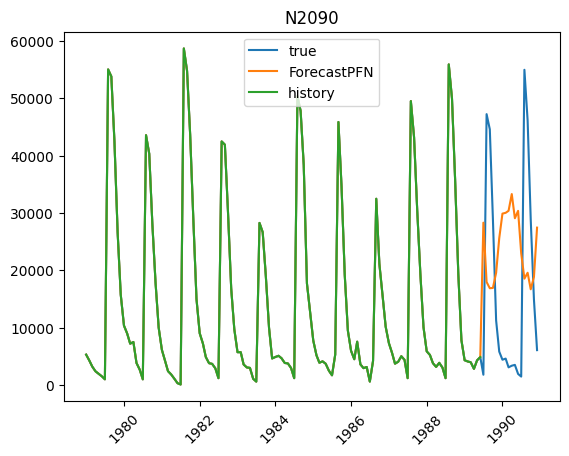

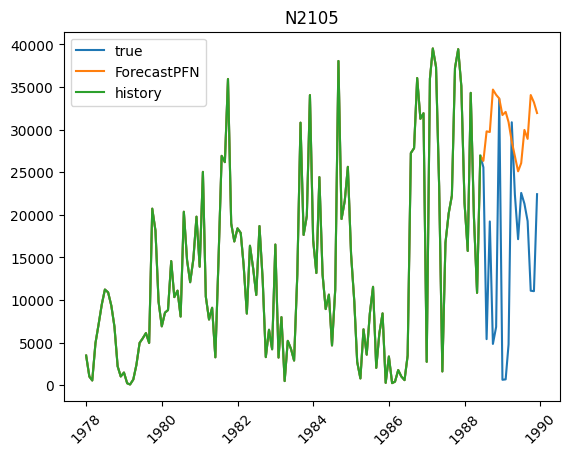

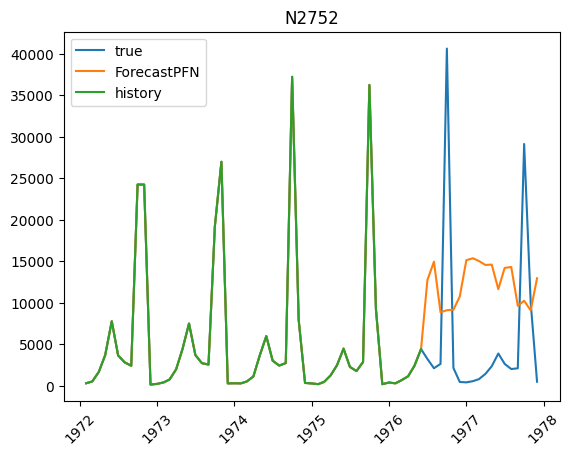

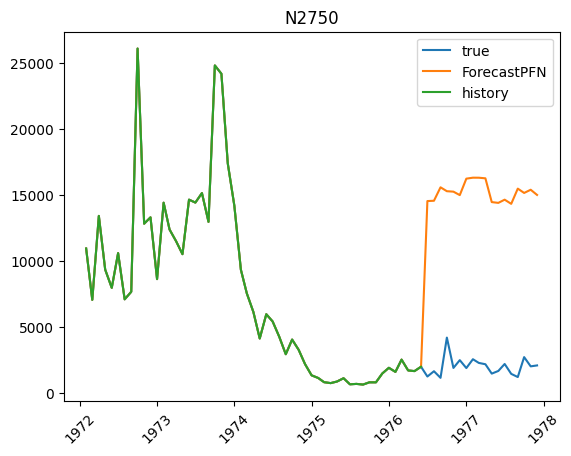

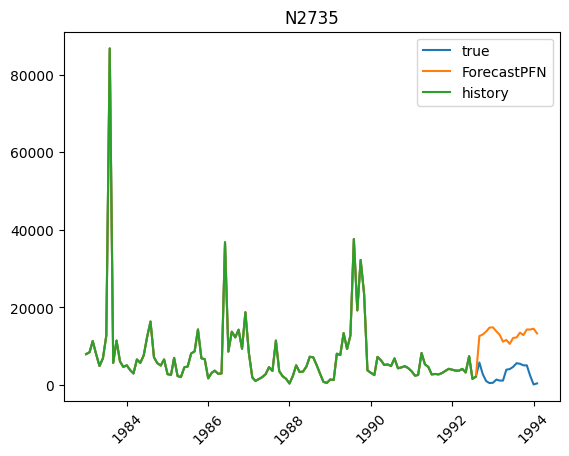

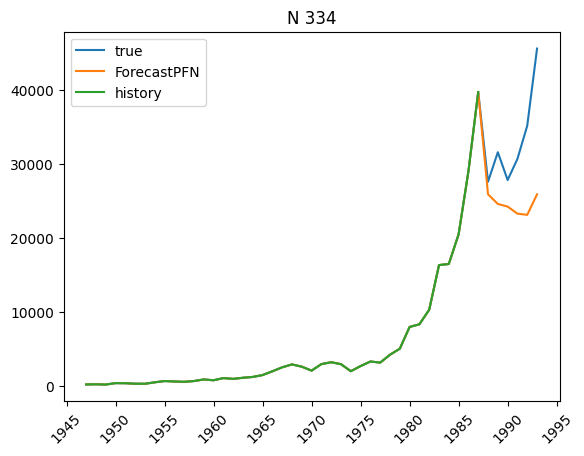

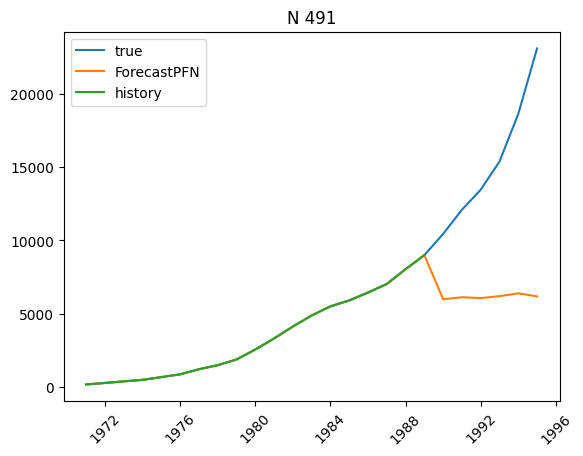

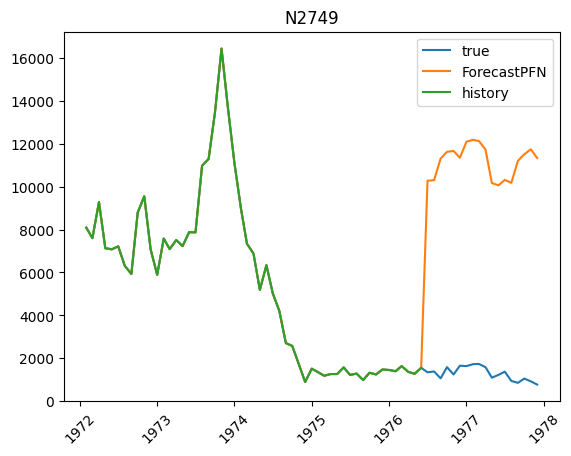

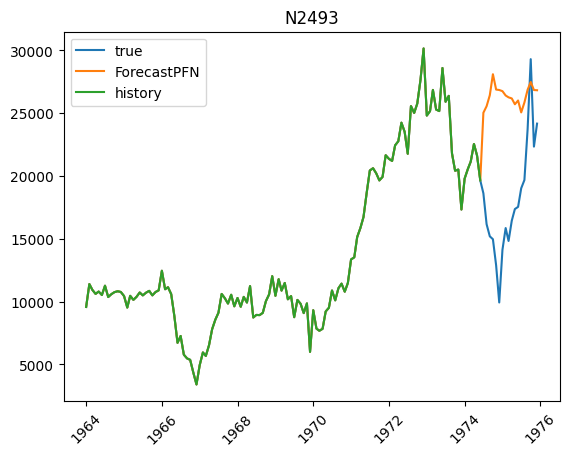

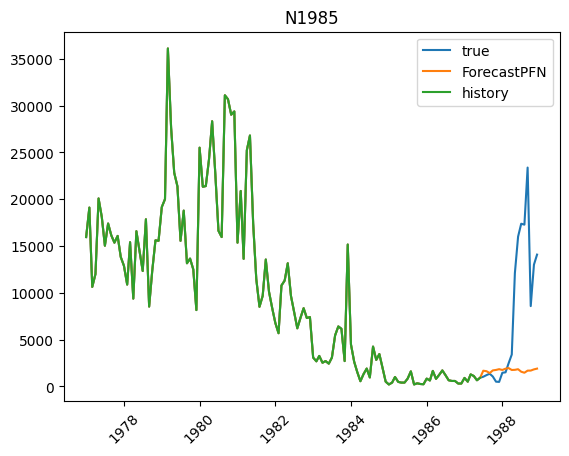

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

desc_sort_mse = pred.sort_values('mse', ascending=False).index
idxs = range(10)
preds = pred.iloc[desc_sort_mse[idxs]]
trues = true.iloc[desc_sort_mse[idxs]]

for (i,p_pfn), (i,y) in zip(preds.iterrows(), trues.iterrows()):
    
    row_idx = i
    row_name = p_pfn['id']
    times = np.append(ts_input[i], ts_output[row_idx])
    x = target_input.values()[i]
    p_pfn = p_pfn[preds.columns[1:-1]]
    y = y[trues.columns[1:]]
    
    
    plt.plot(times, np.append(x,y.dropna()), label="true")
    plt.plot(times, np.append(x,p_pfn.dropna()), label="ForecastPFN")

    plt.plot(ts_input[i], x, label="history")
    plt.legend()
    plt.title(row_name)
    plt.xticks(rotation=45)
    plt.show()





In [13]:
pred['mape']

KeyError: 'mape'